In [1]:
from types import new_class
from allennlp.models import model
from allennlp.models.archival import load_archive
from allennlp.predictors import Predictor
from allennlp.common import Params
from allennlp.data import Vocabulary
from allennlp.data import DataIterator#
from allennlp.data.dataset_readers import DatasetReader
from allennlp.data.dataset_readers.dataset_utils.span_utils import bio_tags_to_spans
from allennlp.models import Model
from allennlp.training import Trainer,checkpointer
from allennlp.training.util import evaluate
from allennlp.common.util import prepare_global_logging, cleanup_global_logging, prepare_environment
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer, PretrainedBertIndexer
from allennlp.data import vocabulary
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import accuracy_score,confusion_matrix

from models import NSDSlotTaggingModel
from predictors import SlotFillingPredictor
from dataset_readers import MultiFileDatasetReader
from metrics import NSDSpanBasedF1Measure
from utils import *

from collections import Counter
from typing import Any, Union, Dict, Iterable, List, Optional, Tuple
from time import *
import numpy as np
import pandas as pd
import argparse
import os
import logging
import torch

vocabulary.DEFAULT_OOV_TOKEN = "[UNK]"  # set for bert

output_dir = "./output/snips_BO"
dataset = "snips_AddToPlaylist_BO"
cuda = 0
threshold = "auto"
batch_size = 256

# Test
time_begin = time()
model_dir = os.path.join(output_dir,dataset)

params = Params.from_file(os.path.join(model_dir,"config.json"))
vocab = Vocabulary.from_files(os.path.join(model_dir,"vocabulary"))
test_bio_data_path = params.pop("test_data_path_bio", None)
test_data_path = params.pop("test_data_path", None)
train_data_path = params.pop("train_data_path", None)
print("test_bio_data_path = ",test_bio_data_path)

# predict
archive = load_archive(model_dir,cuda_device=cuda)
predictor = Predictor.from_archive(archive=archive, predictor_name="slot_filling_predictor")

test_bio_data_path =  ./data/snips_AddToPlaylist_BO/test_bbi


/data1/wyn2020/anaconda3/envs/allennlp0.9/lib/python3.6/site-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
Your BERT model appears to be uncased, but your indexer is not lowercasing tokens.


In [2]:
time_begin = time()
model_dir = os.path.join(output_dir,dataset)

# predict
archive = load_archive(model_dir,cuda_device=cuda)
predictor = Predictor.from_archive(archive=archive, predictor_name="slot_filling_predictor")
# train_outputs = predictor.predict_multi(file_path = train_data_path ,batch_size = batch_size)
test_outputs = predictor.predict_multi(file_path = test_data_path ,batch_size = batch_size)
test_bbi_outputs = predictor.predict_multi(file_path = test_bio_data_path ,batch_size = batch_size)  # bert输出

# input_text = "add sabrina salerno salerno to the grime instrumentals playlist add sabrina salerno salerno to the grime instrumentals playlist" # TODO 用于Debug的样例
# input_label = ['O', 'B-artist', 'I-artist', 'B-artist', 'O', 'O', 'B-playlist', 'I-playlist', 'B-playlist','B-playlist', 'B-artist', 'I-artist', 'B-artist', 'O', 'O', 'B-playlist', 'I-playlist', 'O'] # TODO 用于Debug的样例
# input_bi_label = ['O', 'B-entity', 'B-entity', 'B-entity', 'O', 'O', 'B-entity', 'B-entity', 'B-entity', 'B-entity', 'B-entity', 'B-entity', 'B-entity', 'O', 'O', 'B-entity', 'B-entity', 'O']
# print(input_label)
# print(input_bi_label)
# test_bbi_outputs = predictor.predict({"tokens": input_text.split(),"true_labels":input_bi_label}) # TODO 用于Debug的样例
# test_outputs = predictor.predict({"tokens": input_text.split(),"true_labels":input_label}) # TODO 用于Debug的样例

/data1/wyn2020/anaconda3/envs/allennlp0.9/lib/python3.6/site-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
Your BERT model appears to be uncased, but your indexer is not lowercasing tokens.


output: predict_labels = 1177, true_labels = 1177, encoder_outs = (1177, 256), tokens = 124
output: predict_labels = 1177, true_labels = 1177, encoder_outs = (1177, 256), tokens = 124


In [3]:

# 为计算后边指标，扩展vocab
vocab_labels = list(vocab.get_index_to_token_vocabulary("labels").values())
pred_vocab_labels = list(set(test_outputs["true_labels"]+test_outputs["predict_labels"]))
for pred_label in pred_vocab_labels:
    if pred_label not in vocab_labels: vocab.add_token_to_namespace(pred_label,namespace = "labels") 

print("————————————————————————第一步：（实体识别）计算在目标领域测试集上实体token的识别指标——————————————————————————")
print("- 测试集示例: ")
print("- Ground Truth： ",test_outputs["true_labels"][:10])
print("- Predict Labels: ",test_bbi_outputs["predict_labels"][:10])
entity_true_idx_tens = torch.Tensor([[vocab.get_token_index(label, namespace="labels") for label in test_bbi_outputs["true_labels"]]])
pred_idx = [vocab.get_token_index(label, namespace="labels") for label in test_bbi_outputs["predict_labels"]]  
pred_idx_tens = np.zeros((1,len(test_bbi_outputs["predict_labels"]), vocab.get_vocab_size("labels")),np.int)
for token_ in range(pred_idx_tens.shape[1]):
    pred_idx_tens[0,token_,pred_idx[token_]] = 1  
pred_idx_tens = torch.Tensor(pred_idx_tens)
spanf1 = NSDSpanBasedF1Measure(
                                vocabulary = vocab,
                                tag_namespace="labels",
                                ignore_classes=[],
                                label_encoding="BIO",
                                nsd_slots=["ns"]
                                )
spanf1(pred_idx_tens,entity_true_idx_tens) # pred_idx_tens(1,n_samples,n_classes)，true_idx_tens(1,n_samples)
metric = spanf1.get_metric(reset=True)
f,r,p = round(metric["f1-entity"]*100,2),round(metric["recall-entity"]*100,2),round(metric["precision-entity"]*100,2)
print(f"\n- 在测试集上的eneity指标(token-metrics):  f:{f}, p:{p}, r:{r}")
print("-"*90)
# TODO 可以看一下BIO形式更好还是BO形式更好

print("———————————————————————— 第二步：（聚类）计算聚类指标 ——————————————————————————")
# 提取实体token embedding，以及对应的标注(为了对齐聚类指标以及对聚类效果进行评估)；
true_labels_nobi = [_label if _label=="O" else _label[2:] for _label in test_outputs["true_labels"]]
pred_labels_nobi = [_label if _label=="O" else _label[2:] for _label in test_outputs["predict_labels"]]
true_labels_pd = pd.Series(true_labels_nobi)
pred_labels_pd = pd.Series(pred_labels_nobi)
pred_entity_idx = pred_labels_pd[pred_labels_pd.isin(["entity"])].index
# print("pred_entity_idx = ",pred_entity_idx)
# print("true_labels_pd = \n",true_labels_pd)
# print("pred_labels_pd = \n",pred_labels_pd)
cluster_true_labels = true_labels_pd[pred_entity_idx]
cluster_true_labels = cluster_true_labels.tolist()
token_embeddings = test_outputs["encoder_outs"][pred_entity_idx]
# slots
slots = list(set(true_labels_nobi))
slots.remove("O")
slots_o = list(set(true_labels_nobi))

# 构建 slot_o 与 id 之间的映射关系
vob_clusters_label2id = {}
vob_clusters_id2label = {}
for i, item in enumerate(slots_o):
    vob_clusters_label2id[item] = i
    vob_clusters_id2label[i] = item
print("vob_clusters_label2id = ",vob_clusters_label2id)
gold_cluster_labels = np.array([vob_clusters_label2id[label] for label in cluster_true_labels])

# 将span embedding 输入给kmeans，判断类别；类别与原类别对齐，计算指标.
cluster_contain_o = True
if cluster_contain_o: 
    n_cluster = len(slots_o)
    clusters = slots_o
else:
    n_cluster = len(slots)
    clusters = slots
kmeans = KMeans(init="k-means++", n_clusters=len(slots), n_init=10, random_state=0) # TODO : 算"O"，则n_cluster = len(slots)+1; 否则 n_cluster = len(slots)+1
cluster_pred_labels = kmeans.fit_predict(token_embeddings)
cluster_to_true,cluster_pred_labels = hungray_aligment(y_true=gold_cluster_labels,y_pred=cluster_pred_labels) 
kmeans_metrics(gold_cluster_labels,cluster_pred_labels) # gold_cluster_labels(n_samples),span_embeddings(n_samples, n_features)

cluster_pred_labels = [vob_clusters_id2label[id] for id in cluster_pred_labels]
print("混淆矩阵的标签 = ",clusters)
cm = confusion_matrix(cluster_true_labels,cluster_pred_labels,labels=clusters)
report = classification_report(cluster_true_labels,cluster_pred_labels,labels=clusters)
print("混淆矩阵：\n",cm)
print(report)

print("————————--——————————————————————— 第三步：（规则聚类反馈BIO） ——————————————————————————————————————")
# 先将聚类结果反馈回第一步预测的实体序列
n = 0 
for entity_idx in pred_entity_idx:
    pred_labels_pd[entity_idx] = cluster_pred_labels[n]
    n += 1
# 再利用规则改成BIO形式
# def load_seq_len(data_dir:str):
#     slot_label_file = os.path.join(data_dir, "seq.out")
#     with open(slot_label_file, "r") as f:
#         out_lines = f.readlines()
#     seq_len = [len(out_line.strip().split(" "))
#                     for out_line in out_lines if out_line.strip()]
#     return seq_len
# seq_lens = load_seq_len(data_dir = test_data_path) # list，数据集每个sentence的长度
seq_lens = [9,9]
print("seq_lens = ",seq_lens)
final_pred_labels = []
start_idx,end_idx = 0,0
print(pred_labels_pd)
for seq_len in seq_lens: # 注意一下分句的情况(上句结尾为某tag，下句开头同为某tag)
    start_idx = end_idx # 第x条句子的起始索引
    end_idx = start_idx + seq_len # 第x条句子的终止索引
    seq_pred_labels = pred_labels_pd[start_idx:end_idx].tolist()
    print(seq_pred_labels)
    seq_deque = collections.deque(seq_pred_labels)
    last_item = seq_deque.popleft()
    final_pred_labels.append("O" if last_item=="O" else "B-"+last_item)
    for i in range(len(seq_deque)):
        item = seq_deque.popleft()
        if item == last_item:
            final_pred_labels.append("O" if item=="O" else "I-"+item)
        else:
            final_pred_labels.append("O" if item=="O" else "B-"+item)
        last_item = item
print("final_pred_labels = ",len(final_pred_labels),final_pred_labels)

————————————————————————第一步：（实体识别）计算在目标领域测试集上实体token的识别指标——————————————————————————
- 测试集示例: 
- Ground Truth：  ['O', 'B-artist', 'I-artist', 'O', 'O', 'B-playlist', 'I-playlist', 'O', 'O', 'B-artist']
- Predict Labels:  ['O', 'B-entity', 'B-entity', 'O', 'O', 'B-entity', 'B-entity', 'O', 'O', 'B-entity']

- 在测试集上的eneity指标(token-metrics):  f:90.02, p:96.49, r:84.36
------------------------------------------------------------------------------------------
———————————————————————— 第二步：（聚类）计算聚类指标 ——————————————————————————
vob_clusters_label2id =  {'artist': 0, 'playlist_owner': 1, 'O': 2, 'playlist': 3, 'entity_name': 4, 'music_item': 5}
__________________________________________________________________________________
model		ACC	MI	RI	AMI	ARI	homo	comp	vmeas
kmenas   	0.560	0.657	0.719	0.447	0.320	0.494	0.420	0.454
__________________________________________________________________________________
混淆矩阵的标签 =  ['artist', 'playlist_owner', 'O', 'playlist', 'entity_name', 'music_item']
混淆矩阵：


/data1/wyn2020/anaconda3/envs/allennlp0.9/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data1/wyn2020/anaconda3/envs/allennlp0.9/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data1/wyn2020/anaconda3/envs/allennlp0.9/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

————————--———————————————————————————— (Plot PCA) —————————————--———————————————————————
0           O
1      artist
2      artist
3           O
4           O
5    playlist
6    playlist
7           O
8           O
9      artist
dtype: object
0               O
1          artist
2          artist
3               O
4               O
5        playlist
6        playlist
7               O
8               O
9          artist
10         artist
11              O
12    entity_name
13              O
14              O
15    entity_name
16              O
17              O
dtype: object 18
-----------------------
(1177, 256)
features.shape =  (1177, 2)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1177 but corresponding boolean dimension is 18

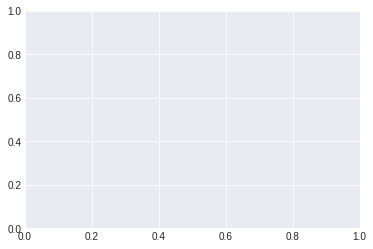

In [38]:


from mpl_toolkits.mplot3d import Axes3D
def pca_3D_visualization(X: np.ndarray,
                      y: pd.Series,
                      classes: List[str],
                      save_path: str):
    """
    Apply PCA visualization for features.
    """
    print("-----------------------")
    print(X.shape)
    red_features = PCA(n_components=3, svd_solver="full").fit_transform(X)
#     print(red_features[:2])
    print("features.shape = ",red_features.shape)

    plt.style.use("seaborn-darkgrid")
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)
    plt.xlabel('X')
    plt.ylabel('Y', rotation=38)  # y 轴名称旋转 38 度
    ax.set_zlabel('Z')  # 因为 plt 不能设置 z 轴坐标轴名称，所以这里只能用 ax 轴来设置（当然，x 轴和 y 轴的坐标轴名称也可以用 ax 设置）

    for _class in classes:
        if _class == "O":
            ax.scatter(red_features[y == _class, 0], red_features[y == _class, 1], red_features[y == _class, 2],
                    label=_class, alpha=0.5, s=10, edgecolors='none', color="gray")
        else:
            ax.scatter(red_features[y == _class, 0], red_features[y == _class, 1], red_features[y == _class, 2],
                    label=_class, alpha=0.5, s=10, edgecolors='none', zorder=15)
    ax.legend(loc=2)
    ax.grid(True)
#     plt.axis('off')
#     plt.show()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0, format="pdf")
#     plt.savefig(save_path, format="png")
def pca_2D_visualization(X: np.ndarray,
                      y: pd.Series,
                      classes: List[str],
                      save_path: str):
    """
    Apply PCA visualization for features.
    """
    print("-----------------------")
    print(X.shape)
    red_features = PCA(n_components=2, svd_solver="full").fit_transform(X)
    print("features.shape = ",red_features.shape)

    plt.style.use("seaborn-darkgrid")
#     fig,ax = plt.figure(figsize=(10,10))
    fig, ax = plt.subplots()
    for _class in classes:
        if _class == "O":
            ax.scatter(red_features[y == _class, 0], red_features[y == _class, 1], 
                    label=_class, alpha=0.5, s=10, edgecolors='none', color="gray")
        else:
            ax.scatter(red_features[y == _class, 0], red_features[y == _class, 1],
                    label=_class, alpha=0.5, s=10, edgecolors='none', zorder=15)
    ax.legend(loc=2)
    ax.grid(True)
#     plt.axis('off')
#     plt.show()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0, format="pdf")
#     plt.savefig(save_path, format="png")
print("————————--———————————————————————————— (Plot PCA) —————————————--———————————————————————")
true_slot_o = pd.Series([label if label == "O" else label[2:] for label in test_outputs["true_labels"]])
pred_slot_o = pd.Series([label if label == "O" else label[2:] for label in final_pred_labels])
print(true_slot_o[:10])
print(pred_slot_o,len(pred_slot_o))

pca_2D_visualization(test_outputs["encoder_outs"],pred_slot_o,clusters,os.path.join("./error_study",dataset+"_2D_pred.pdf"))
pca_3D_visualization(test_outputs["encoder_outs"],pred_slot_o,clusters,os.path.join("./error_study",dataset+"_3D_pred.pdf"))



In [ ]:
print("hello")